# Semana 3 - Desafio de Transformação dos Dados

Olá novamente colegx! Me chamo Wesley e este é meu notebook que contém as minhas resoluções para os desafios propostos na semana 3, da aceleração PySpark na Capgemini. 

O desafio desta semana tem como base os datasets e estruturas que utilizamos na semana passada (ver notebook[¹]), mas agora focaremos na transformação dos dados, parte importante para ciência de dados. Não se esqueça de deixar uma mensagem, caso tenha dúvidas ou sugestões, baixe o notebook e explore o quanto precisar, e não deixe de se divertir no processo.

Sem mais delongas, vamos  ao setup:

[¹]: https://datalore.jetbrains.com/view/notebook/x0MVKk2Igo1mmrKK6LWTjY

In [1]:
# Installing required packages
!pip install pyspark
!pip install findspark

You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


In [2]:
import findspark
findspark.init()

In [3]:
import re
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType

In [4]:
# Expressoes regulares comuns
REGEX_ALPHA    = r'[a-zA-Z]+'
REGEX_INTEGER  = r'[0-9]+'
REGEX_FLOAT    = r'[0-9]+\.[0-9]+'
REGEX_ALPHANUM = r'[0-9a-zA-Z]+'
REGEX_EMPTY_STR= r'[\t ]+$'
REGEX_SPECIAL  = r'[!@#$%&*\(\)_]+'
REGEX_NNUMBER  = r'^N[1-9][0-9]{2,3}([ABCDEFGHJKLMNPRSTUVXWYZ]{1,2})'
REGEX_NNUMBER_INVALID = r'(N0.*$)|(.*[IO].*)'
REGEX_TIME_FMT = r'^(([0-1]?[0-9])|(2[0-3]))([0-5][0-9])$'

In [5]:
# Criar o contexto do spark
sc = SparkContext()

# Instancia o criador de sessao do spark
spark = (SparkSession.builder
                     .master("local[7]")
                     .appName("Desafio Transformação - Aceleração PySpark/Capgemini"))

In [6]:
#helper functions
def check_empty_column(col):
    return (F.col(col).isNull() | (F.col(col) == '') | F.col(col).rlike(REGEX_EMPTY_STR))

def check_column_range(col, from_value, to_value, leftInclusive = False, rightIncluse = False):
    check_range_expression = "(" + str(F.col(col)) + (" >= " if leftInclusive else " > ") + str(from_value) + " and " \
                                 + str(F.col(col)) + (" <= " if rightIncluse  else " < ") +")" 
    return eval(check_range_expression)
    
def create_regex_from_list(_list):
    return r'|'.join(map(lambda x : f".*({x}).*", _list))

In [7]:
schema_airports = StructType([
    StructField("faa",  StringType(),  True),
    StructField("name", StringType(),  True),
    StructField("lat",  FloatType(),   True),
    StructField("lon",  FloatType(),   True),
    StructField("alt",  IntegerType(), True),
    StructField("tz",   IntegerType(), True),
    StructField("dst",  StringType(),  True)
])

schema_planes = StructType([
    StructField("tailnum",      StringType(),  True),
    StructField("year",         IntegerType(), True),
    StructField("type",         StringType(),  True),
    StructField("manufacturer", StringType(),  True),
    StructField("model",        StringType(),  True),
    StructField("engines",      IntegerType(), True),
    StructField("seats",        IntegerType(), True),
    StructField("speed",        IntegerType(), True),
    StructField("engine",       StringType(),  True)
])

schema_flights = StructType([
    StructField("year",      IntegerType(), True),
    StructField("month",     IntegerType(), True),
    StructField("day",       IntegerType(), True),
    StructField("dep_time",  StringType(),  True),
    StructField("dep_delay", IntegerType(), True),
    StructField("arr_time",  StringType(),  True),
    StructField("arr_delay", IntegerType(), True),
    StructField("carrier",   StringType(),  True),
    StructField("tailnum",   StringType(),  True),
    StructField("flight",    StringType(),  True),
    StructField("origin",    StringType(),  True),
    StructField("dest",      StringType(),  True),
    StructField("air_time",  IntegerType(), True),
    StructField("distance",  IntegerType(), True),
    StructField("hour",      IntegerType(), True),
    StructField("minute",    IntegerType(), True),
])

In [8]:
df_airports = (spark.getOrCreate().read
               .format('csv')
               .option("inferSchema", "false") 
               .option('header', "true")
               .schema(schema_airports)
               .load('./datasets/airports.csv'))
df_planes = (spark.getOrCreate().read
             .format('csv')
             .option('inferSchema', 'false')
             .option('header', 'true')
             .schema(schema_planes)
             .load('./datasets/planes.csv'))
df_flights = (spark.getOrCreate().read
              .format('csv')
              .option("inferSchema", "false")
              .option("header", "true")
              .load('./datasets/flights.csv'))

In [9]:
df_airports.createOrReplaceTempView('airports_view')
df_flights.createOrReplaceTempView('flights_view')
df_planes.createOrReplaceTempView('planes_view')

In [10]:
#RDDs
rdd_airports = df_airports.rdd
df_planes    = df_planes.rdd
df_flights   = df_flights.rdd

In [11]:
def add_test_rows_for_airports(data, _format):
    """ Adiciona linhas para testar regras de negócio"""
    
    values = [
        #faa    name  lat       lon               alt       tz    dst
        (None , None, None    , None            , None    , None, None),
        (''   , ''  , ''      , ''              , ''      , ''  , ''  ),
        ('   ', None, '12O.12', '-80.Aa6195833' , '1044Aa', '-2x', '34'),
        ('AAA', None, '12O.12', '-80.Aa6195833' , '1044Aa', '-2x', '34'),
        ('222', None, None    , '-80.Aa6195833' , '-100'  , '-14', 'K'),
        ('__!', None, None    , '-80.Aa6195833' , '-100'  , '-14', 'K')
    ]
 
    if _format == "df":
        return spark.getOrCreate().createDataFrame(values, data.columns).union(data)
    elif _format == "rdd":
        return sc.parallelize(tuple(values)).union(data)

In [12]:
df_airports  = add_test_rows_for_airports(df_airports,  "df")
rdd_airports = add_test_rows_for_airports(rdd_airports, "rdd")

In [13]:
df_airports.show(10)

+----+--------------------+---------+-------------+------+----+----+
| faa|                name|      lat|          lon|   alt|  tz| dst|
+----+--------------------+---------+-------------+------+----+----+
|null|                null|     null|         null|  null|null|null|
|    |                    |         |             |      |    |    |
|    |                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|
| AAA|                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|
| 222|                null|     null|-80.Aa6195833|  -100| -14|   K|
| __!|                null|     null|-80.Aa6195833|  -100| -14|   K|
| 04G|                null|41.130474|    -80.61958|  1044|  -5|  22|
| 06A|Moton Field Munic...| 32.46057|    -85.68003|   264|  -5|   A|
| 06C| Schaumburg Regional| 41.98934|    -88.10124|   801|  -6|   F|
| 06N|     Randall Airport| 41.43191|    -74.39156|   523|  -5|   A|
+----+--------------------+---------+-------------+------+----+----+
only showing top 10 rows



In [14]:
rdd_airports.take(10)

[(None, None, None, None, None, None, None),
 ('', '', '', '', '', '', ''),
 ('   ', None, '12O.12', '-80.Aa6195833', '1044Aa', '-2x', '34'),
 ('AAA', None, '12O.12', '-80.Aa6195833', '1044Aa', '-2x', '34'),
 ('222', None, None, '-80.Aa6195833', '-100', '-14', 'K'),
 ('__!', None, None, '-80.Aa6195833', '-100', '-14', 'K'),
 Row(faa='04G', name=None, lat=41.13047409057617, lon=-80.61958312988281, alt=1044, tz=-5, dst='22'),
 Row(faa='06A', name='Moton Field Municipal Airport', lat=32.4605712890625, lon=-85.6800308227539, alt=264, tz=-5, dst='A'),
 Row(faa='06C', name='Schaumburg Regional', lat=41.989341735839844, lon=-88.10124206542969, alt=801, tz=-6, dst='F'),
 Row(faa='06N', name='Randall Airport', lat=41.43191146850586, lon=-74.39156341552734, alt=523, tz=-5, dst='A')]

# Airports Dataset

![Airport](attachment:./images/airports_snapshot.png "a Crowded airport")
<p style="text-align: center;">

Considere o dataset airports.csv para realizar as seguintes tarefas:
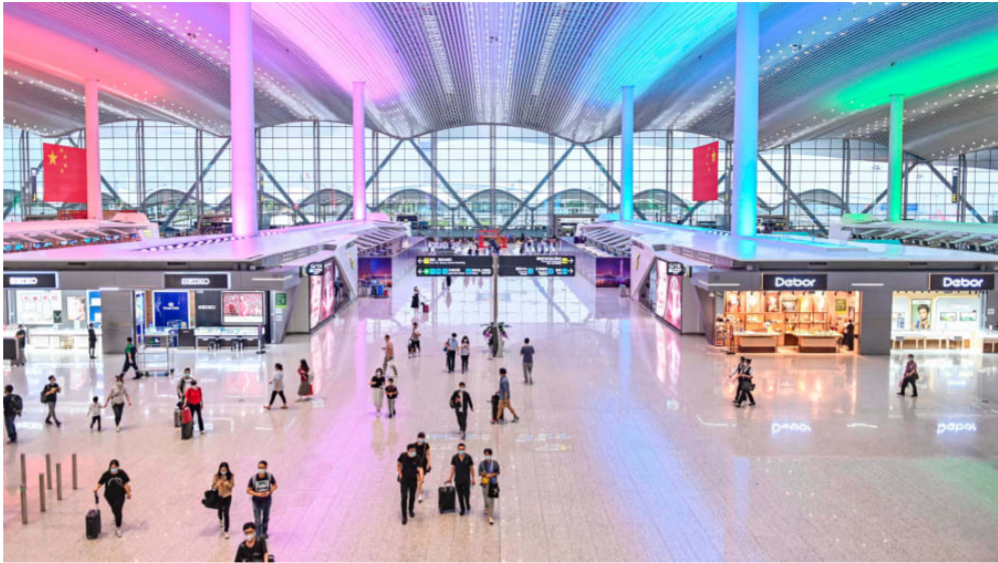

Buenas

In [15]:
# df_airports = df_airports.select("*",
#                                 (F.when(
#                                     F.col('alt') < 0, 0
#                                 ).when(
#                                     check_empty_column('alt'), "M"
#                                 ).otherwise(F.col('alt')))
#                             )

df_airports = df_airports.withColumn('alt',(
    F.when(
        F.col('alt') < 0, 0)
     .when(
        check_empty_column('alt'), "M"
      ).otherwise(F.col('alt'))
))
#df_airports.select('*').where(df_airports.alt ==  0).show()

#with RDD



#with SQL
spark.sql(f"""
SELECT *, CASE
            WHEN alt RLIKE '{REGEX_EMPTY_STR}' OR alt IS NULL OR alt LIKE '' THEN ''
            WHEN alt < 0 THEN 0
            OTHERWISE alt
          END AS alt
FROM airports_view
""").show(5)

df_airports.show(15)

+---+--------------------+---------+-------------+---+---+---+
|faa|                name|      lat|          lon|alt| tz|dst|
+---+--------------------+---------+-------------+---+---+---+
|222|                null|     null|-80.Aa6195833|  0|-14|  K|
|__!|                null|     null|-80.Aa6195833|  0|-14|  K|
|AGN|Angoon Seaplane Base|57.503613|     -134.585|  0| -9|  A|
|ALZ|Alitak Seaplane Base|56.899445|   -154.24777|  0| -9|  A|
|AOS|Amook Bay Seaplan...| 57.47139|   -153.81528|  0| -9|  A|
|AQC|Klawock Seaplane ...|55.554657|    -133.1017|  0| -9|  A|
|ATT|Camp Mabry Austin...| 30.31666|     -97.7666|  0| -6|  A|
|BYW|Blakely Island Ai...| 48.56025|   -122.80243|  0| -8|  A|
|CGA| Craig Seaplane Base| 55.47889|   -133.14778|  0| -9|  A|
|CYM|Chatham Seaplane ...|   57.515|    -134.9461|  0| -9|  A|
|ELV|Elfin Cove Seapla...| 58.19528|    -136.3475|  0| -9|  A|
|EXI|Excursion Inlet S...|58.420555|   -135.44917|  0| -9|  A|
|FBS|Friday Harbor Sea...|48.537224|   -123.00972|  0| 

tardes ou

In [16]:
df_airports = df_airports.withColumn('dst', (
    F.when(
        (F.col('tz') >= -7) &
        (F.col('tz') <= -5), 'A'
    ).otherwise(F.col('dst'))
))
    
df_airports.show(15)

+----+--------------------+---------+-------------+------+----+----+
| faa|                name|      lat|          lon|   alt|  tz| dst|
+----+--------------------+---------+-------------+------+----+----+
|null|                null|     null|         null|     M|null|null|
|    |                    |         |             |     M|    |    |
|    |                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|
| AAA|                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|
| 222|                null|     null|-80.Aa6195833|     0| -14|   K|
| __!|                null|     null|-80.Aa6195833|     0| -14|   K|
| 04G|                null|41.130474|    -80.61958|  1044|  -5|   A|
| 06A|Moton Field Munic...| 32.46057|    -85.68003|   264|  -5|   A|
| 06C| Schaumburg Regional| 41.98934|    -88.10124|   801|  -6|   A|
| 06N|     Randall Airport| 41.43191|    -74.39156|   523|  -5|   A|
| 09J|Jekyll Island Air...|31.074472|    -81.42778|    11|  -4|   A|
| 0A9|Elizabethton Muni...|36.3712

noches

In [17]:
df_airports = df_airports.withColumn('dst', (
    F.when(
        (F.col('dst') == 'U'), 'A'
    ).otherwise(F.col('dst'))
))

df_airports.show(15)

+----+--------------------+---------+-------------+------+----+----+
| faa|                name|      lat|          lon|   alt|  tz| dst|
+----+--------------------+---------+-------------+------+----+----+
|null|                null|     null|         null|     M|null|null|
|    |                    |         |             |     M|    |    |
|    |                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|
| AAA|                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|
| 222|                null|     null|-80.Aa6195833|     0| -14|   K|
| __!|                null|     null|-80.Aa6195833|     0| -14|   K|
| 04G|                null|41.130474|    -80.61958|  1044|  -5|   A|
| 06A|Moton Field Munic...| 32.46057|    -85.68003|   264|  -5|   A|
| 06C| Schaumburg Regional| 41.98934|    -88.10124|   801|  -6|   A|
| 06N|     Randall Airport| 41.43191|    -74.39156|   523|  -5|   A|
| 09J|Jekyll Island Air...|31.074472|    -81.42778|    11|  -4|   A|
| 0A9|Elizabethton Muni...|36.3712

para

In [18]:
#check_column_range('lon', -50, 24)

df_airports = df_airports.withColumn('region', (
    F.when(
        F.col('lon') < -124, 'ALASKA'
    ).when(
        ((F.col('lon') > -50) |
         (F.col('lat') < 24)), 'OFFSHORE'
    ).when(
        F.col('lon') <= -95, 'MAINLAND-WEST'
    ).when(
        F.col('lon') >= -95, 'MAINLAND-EAST'
    ).otherwise('NaN')
))

df_airports.show(15)

+----+--------------------+---------+-------------+------+----+----+-------------+
| faa|                name|      lat|          lon|   alt|  tz| dst|       region|
+----+--------------------+---------+-------------+------+----+----+-------------+
|null|                null|     null|         null|     M|null|null|          NaN|
|    |                    |         |             |     M|    |    |          NaN|
|    |                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|          NaN|
| AAA|                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|          NaN|
| 222|                null|     null|-80.Aa6195833|     0| -14|   K|          NaN|
| __!|                null|     null|-80.Aa6195833|     0| -14|   K|          NaN|
| 04G|                null|41.130474|    -80.61958|  1044|  -5|   A|MAINLAND-EAST|
| 06A|Moton Field Munic...| 32.46057|    -85.68003|   264|  -5|   A|MAINLAND-EAST|
| 06C| Schaumburg Regional| 41.98934|    -88.10124|   801|  -6|   A|MAINLAND-EAST|
| 06

Usted

In [19]:
# Usando dataframe
AP_TYPES = ["Airport", "Tradeport", "Heliport", "Airpor", "Arpt"]

df_airports = df_airports.withColumn('type',(
        F.when(F.col('name').rlike(create_regex_from_list(AP_TYPES)), 'AP')
         .when(F.col('name').rlike("(AERODROME)"), 'AD')
         .when((
             (F.col('name').rlike(create_regex_from_list(["Airpark", 'Aero Park']))) 
         ), 'AS')
         .when(
             (F.col('name').rlike(create_regex_from_list(['Field', "Fld"]))), 'FL'
         ).otherwise('NaN')
    ))

df_airports.show(15)

+----+--------------------+---------+-------------+------+----+----+-------------+----+
| faa|                name|      lat|          lon|   alt|  tz| dst|       region|type|
+----+--------------------+---------+-------------+------+----+----+-------------+----+
|null|                null|     null|         null|     M|null|null|          NaN| NaN|
|    |                    |         |             |     M|    |    |          NaN| NaN|
|    |                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|          NaN| NaN|
| AAA|                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|          NaN| NaN|
| 222|                null|     null|-80.Aa6195833|     0| -14|   K|          NaN| NaN|
| __!|                null|     null|-80.Aa6195833|     0| -14|   K|          NaN| NaN|
| 04G|                null|41.130474|    -80.61958|  1044|  -5|   A|MAINLAND-EAST| NaN|
| 06A|Moton Field Munic...| 32.46057|    -85.68003|   264|  -5|   A|MAINLAND-EAST|  AP|
| 06C| Schaumburg Regional| 41.9

meu caro

In [20]:
# Usando dataframe
MILITARY_TYPES = ["Base", "Aaf", "AFs", "Ahp", "Afb", "LRRS", "Lrrs", "Arb", "Naf", "NAS", "Nas", "Jrb", "Ns",
"As", "Cgas", "Angb"]

df_airports = df_airports.withColumn('military',(
        F.when(
            F.col('name').rlike(create_regex_from_list(MILITARY_TYPES)), True
        ).otherwise(False)
    ))

df_airports.show(15)

+----+--------------------+---------+-------------+------+----+----+-------------+----+--------+
| faa|                name|      lat|          lon|   alt|  tz| dst|       region|type|military|
+----+--------------------+---------+-------------+------+----+----+-------------+----+--------+
|null|                null|     null|         null|     M|null|null|          NaN| NaN|   false|
|    |                    |         |             |     M|    |    |          NaN| NaN|   false|
|    |                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|          NaN| NaN|   false|
| AAA|                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|          NaN| NaN|   false|
| 222|                null|     null|-80.Aa6195833|     0| -14|   K|          NaN| NaN|   false|
| __!|                null|     null|-80.Aa6195833|     0| -14|   K|          NaN| NaN|   false|
| 04G|                null|41.130474|    -80.61958|  1044|  -5|   A|MAINLAND-EAST| NaN|   false|
| 06A|Moton Field Munic...| 32

In [22]:
df_airports.select('*').where(df_airports.military != False).show()

+---+--------------------+---------+-----------+----+---+---+-------------+----+--------+--------------+
|faa|                name|      lat|        lon| alt| tz|dst|       region|type|military|administration|
+---+--------------------+---------+-----------+----+---+---+-------------+----+--------+--------------+
|3G4|Ashland County Ai...|40.902973|  -82.25564|1206| -5|  A|MAINLAND-EAST|  AP|    true|             R|
|ADW|         Andrews Afb|38.810806|  -76.86703| 280| -5|  A|MAINLAND-EAST| NaN|    true|           NaN|
|AGN|Angoon Seaplane Base|57.503613|   -134.585|   0| -9|  A|       ALASKA| NaN|    true|           NaN|
|ALZ|Alitak Seaplane Base|56.899445| -154.24777|   0| -9|  A|       ALASKA| NaN|    true|           NaN|
|AOS|Amook Bay Seaplan...| 57.47139| -153.81528|   0| -9|  A|       ALASKA| NaN|    true|           NaN|
|APG|        Phillips Aaf| 39.46622|  -76.16881|  57| -5|  A|MAINLAND-EAST| NaN|    true|           NaN|
|AQC|Klawock Seaplane ...|55.554657|  -133.1017|   0| -

cumpadre

In [21]:
#lists
I_TYPES = ["International", "Intl", "Intercontinental"]
N_TYPES = ["National", "Natl"]
R_TYPES = ["Regional", "Reigonal", "Rgnl", "County", "Metro" "Metropolitan"]
M_TYPES = ["Municipal", "Muni", 'City']

# Usando dataframe
df_airports = df_airports.withColumn('administration',(
        F.when(
            F.col('name').rlike(create_regex_from_list(I_TYPES)), 'I'
        ).when(
            F.col('name').rlike(create_regex_from_list(N_TYPES)), 'N'
        ).when(
            F.col('name').rlike(create_regex_from_list(R_TYPES)), 'R'
        ).when(
            F.col('name').rlike(create_regex_from_list(M_TYPES)), 'M'
        ).otherwise('NaN')
    ))

df_airports.show(15)

+----+--------------------+---------+-------------+------+----+----+-------------+----+--------+--------------+
| faa|                name|      lat|          lon|   alt|  tz| dst|       region|type|military|administration|
+----+--------------------+---------+-------------+------+----+----+-------------+----+--------+--------------+
|null|                null|     null|         null|     M|null|null|          NaN| NaN|   false|           NaN|
|    |                    |         |             |     M|    |    |          NaN| NaN|   false|           NaN|
|    |                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|          NaN| NaN|   false|           NaN|
| AAA|                null|   12O.12|-80.Aa6195833|1044Aa| -2x|  34|          NaN| NaN|   false|           NaN|
| 222|                null|     null|-80.Aa6195833|     0| -14|   K|          NaN| NaN|   false|           NaN|
| __!|                null|     null|-80.Aa6195833|     0| -14|   K|          NaN| NaN|   false|        